## Imports and utility functions

In [1]:
!pip install xarray cdsapi

In [2]:
import xarray
from typing import Optional
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import math
import pandas as pd
import cdsapi
import scipy

In [3]:
def select(
    data: xarray.Dataset,
    variable: str,
    level: Optional[int] = None,
    max_steps: Optional[int] = None
    ) -> xarray.Dataset:
  data = data[variable]
  if "batch" in data.dims:
    data = data.isel(batch=0)
  if max_steps is not None and "time" in data.sizes and max_steps < data.sizes["time"]:
    data = data.isel(time=range(0, max_steps))
  if level is not None and "level" in data.coords:
    data = data.sel(level=level)
  return data

def scale(
    data: xarray.Dataset,
    center: Optional[float] = None,
    robust: bool = False,
    ) -> tuple[xarray.Dataset, colors.Normalize, str]:
  vmin = np.nanpercentile(data, (2 if robust else 0))
  vmax = np.nanpercentile(data, (98 if robust else 100))
  if center is not None:
    diff = max(vmax - center, center - vmin)
    vmin = center - diff
    vmax = center + diff
  return (data, colors.Normalize(vmin, vmax),
          ("RdBu_r" if center is not None else "viridis"))

def plot_data(
    data: dict[str, xarray.Dataset],
    fig_title: str,
    plot_size: float = 5,
    robust: bool = False,
    cols: int = 4
    ) -> tuple[xarray.Dataset, colors.Normalize, str]:

  first_data = next(iter(data.values()))[0]
  max_steps = first_data.sizes.get("time", 1)
  assert all(max_steps == d.sizes.get("time", 1) for d, _, _ in data.values())

  cols = min(cols, len(data))
  rows = math.ceil(len(data) / cols)
  figure = plt.figure(figsize=(plot_size * 2 * cols,
                               plot_size * rows))
  figure.suptitle(fig_title, fontsize=16)
  figure.subplots_adjust(wspace=0, hspace=0)
  figure.tight_layout()

  images = []
  for i, (title, (plot_data, norm, cmap)) in enumerate(data.items()):
    ax = figure.add_subplot(rows, cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    im = ax.imshow(
        plot_data.isel(time=0, missing_dims="ignore"), norm=norm,
        origin="lower", cmap=cmap)
    plt.colorbar(
        mappable=im,
        ax=ax,
        orientation="vertical",
        pad=0.02,
        aspect=16,
        shrink=0.75,
        cmap=cmap,
        extend=("both" if robust else "neither"))
    images.append(im)

## Plot input data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd drive/MyDrive/3A\ CS/Cours\ MVA/IA\ et\ environnement/Project

/content/drive/MyDrive/3A CS/Cours MVA/IA et environnement/Project


In [6]:
!ls

graphcast.dockerfile  plots.ipynb    predictions.csv	README.md	  single-level.nc
graphcast.yaml	      prediction.py  pressure-level.nc	requirements.txt


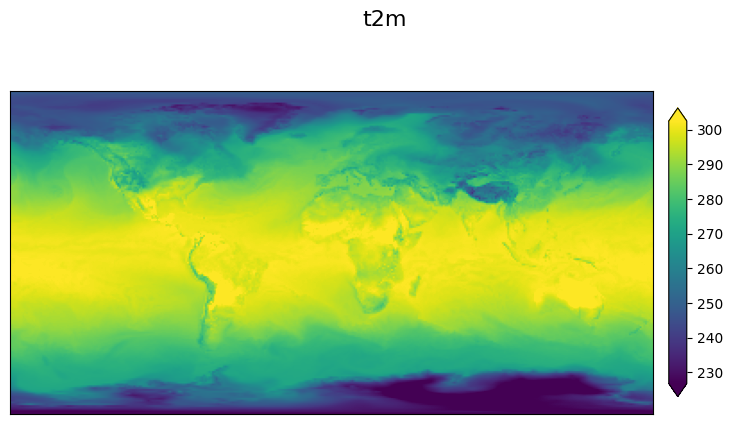

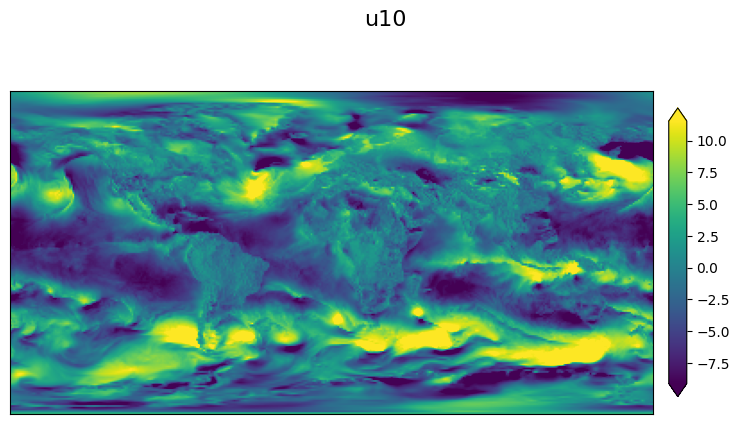

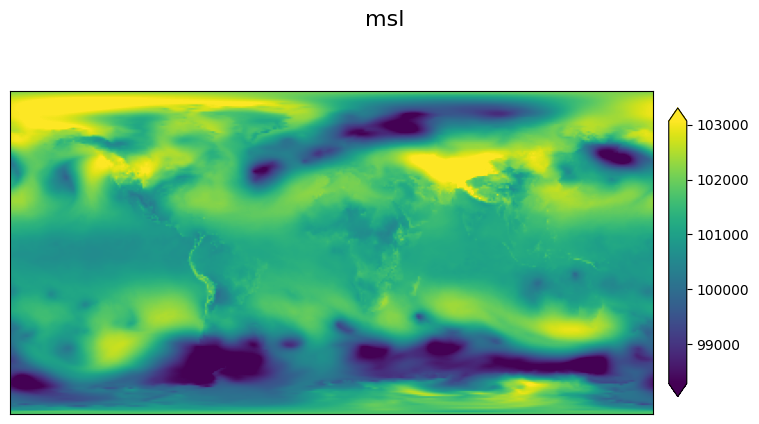

In [7]:
plot_size = 5

with open("single-level.nc", "rb") as f:
  example_batch = xarray.load_dataset(f).compute()

# Europe in the middle + Map not upside down :
# in the longitude dimension, map values higher than 180 to values - 360
example_batch["longitude"] = xarray.where(example_batch['longitude'] > 180, example_batch['longitude'] - 360, example_batch['longitude'])
# sort example_batch by latitude and longitude
example_batch = example_batch.sortby(["latitude", "longitude"])

plot_example_level = 50
plot_example_max_steps = 1
plot_example_robust = True

variables = ["t2m", "u10", "msl"]

for variable in variables:
  plot_example_variable = variable

  data = {
      " ": scale(select(example_batch, plot_example_variable, plot_example_level, plot_example_max_steps),
                robust=plot_example_robust),
  }
  fig_title = plot_example_variable
  if "level" in example_batch[plot_example_variable].coords:
    fig_title += f" at {plot_example_level} hPa"

  plot_data(data, fig_title, plot_size, plot_example_robust)

## Plot predicted data

### Fetch the real target data

In [8]:
url = 'url: https://cds.climate.copernicus.eu/api/v2'
key = 'key: 293952:60356953-f923-4058-b619-85cbe4945d1c'

with open('/root/.cdsapirc', 'w') as f:
    f.write('\n'.join([url, key]))

with open('/root/.cdsapirc') as f:
    print(f.read())

url: https://cds.climate.copernicus.eu/api/v2
key: 293952:60356953-f923-4058-b619-85cbe4945d1c


In [9]:
client = cdsapi.Client()

In [10]:
day = 15
month = 3
year = 2024

singlelevelfields = [
                        '10m_u_component_of_wind',
                        '10m_v_component_of_wind',
                        '2m_temperature',
                        'geopotential',
                        'land_sea_mask',
                        'mean_sea_level_pressure',
                        'toa_incident_solar_radiation',
                        'total_precipitation'
                    ]

client.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': singlelevelfields,
        'grid': '1.0/1.0',
        'year': [year],
        'month': [month],
        'day': [day],
        'time': ['18:00'], # time of first prediction
        'format': 'netcdf'
    },
    'single-level-truth.nc'
)

2024-03-26 11:38:44,185 INFO Welcome to the CDS
INFO:cdsapi:Welcome to the CDS
2024-03-26 11:38:44,189 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
INFO:cdsapi:Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-03-26 11:38:44,333 INFO Request is queued
INFO:cdsapi:Request is queued
2024-03-26 11:43:04,100 INFO Request is completed
INFO:cdsapi:Request is completed
2024-03-26 11:43:04,104 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data1/adaptor.mars.internal-1711453335.903796-18702-14-439bb14c-ddf4-4e56-a519-fe7540978806.nc to single-level-truth.nc (1023.1K)
INFO:cdsapi:Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data1/adaptor.mars.internal-1711453335.903796-18702-14-439bb14c-ddf4-4e56-a519-fe7540978806.nc to single-level-truth.nc (1023.1K)
2024-03-26 11:43:05,589 INFO Download rate 69

Result(content_length=1047664,content_type=application/x-netcdf,location=https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data1/adaptor.mars.internal-1711453335.903796-18702-14-439bb14c-ddf4-4e56-a519-fe7540978806.nc)

In [11]:
with open("single-level-truth.nc", "rb") as f:
  eval_targets = xarray.load_dataset(f).compute()

# Europe in the middle + Map not upside down :
# in the longitude dimension, map values higher than 180 to values - 360
eval_targets["longitude"] = xarray.where(eval_targets['longitude'] > 180, eval_targets['longitude'] - 360, eval_targets['longitude'])
# sort example_batch by latitude and longitude
eval_targets = eval_targets.sortby(["latitude", "longitude"])

### Compare with predictions

In [12]:
predictions = pd.read_csv("predictions.csv")
predictions = predictions.rename(columns = {"lon": "longitude", "lat": "latitude", "10m_u_component_of_wind": "u10", "10m_v_component_of_wind": "v10", "2m_temperature": "t2m", "geopotential":"z", "mean_sea_level_pressure":"msl", "total_precipitation_6hr":"tp"})

# select only one pressure level (closest to surface)
predictions = predictions.loc[(predictions.level == 50)]
predictions["time"] = pd.to_datetime(predictions["time"])
predictions["longitude"] = predictions["longitude"].apply(lambda x: x - 360 if x > 180 else x)
predictions.sort_values(by = ['longitude', 'latitude', 'time'], inplace = True)
predictions.set_index(['time', 'latitude', 'longitude'], inplace = True)
predictions = predictions.drop(['batch','level'], axis = 1)
predictions = xarray.Dataset.from_dataframe(predictions)

# convert all floats to float32
predictions = predictions.astype(np.float32)

predictions

<ipython-input-12-400ea0ca7363>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["time"] = pd.to_datetime(predictions["time"])
<ipython-input-12-400ea0ca7363>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["longitude"] = predictions["longitude"].apply(lambda x: x - 360 if x > 180 else x)
<ipython-input-12-400ea0ca7363>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

<xarray.Dataset>
Dimensions:              (time: 4, latitude: 181, longitude: 360)
Coordinates:
  * time                 (time) datetime64[ns] 2024-03-15T18:00:00 ... 2024-0...
  * latitude             (latitude) float64 -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * longitude            (longitude) float64 -179.0 -178.0 ... 179.0 180.0
Data variables:
    u10                  (time, latitude, longitude) float32 3.752 ... 0.7405
    v10                  (time, latitude, longitude) float32 -0.2299 ... 1.535
    t2m                  (time, latitude, longitude) float32 229.8 ... 253.4
    z                    (time, latitude, longitude) float32 1.952e+05 ... 1....
    msl                  (time, latitude, longitude) float32 1.011e+05 ... 1....
    specific_humidity    (time, latitude, longitude) float32 2.967e-06 ... 2....
    temperature          (time, latitude, longitude) float32 219.4 ... 234.3
    tp                   (time, latitude, longitude) float32 -9.15e-05 ... -0...
    u_component_of_wind  (time, latitude, longitude) float32 13.19 ... 10.01
    v_component_of_wind  (time, latitude, longitude) float32 -5.482 ... -6.297
    vertical_velocity    (time, latitude, longitude) float32 -0.009784 ... -0...

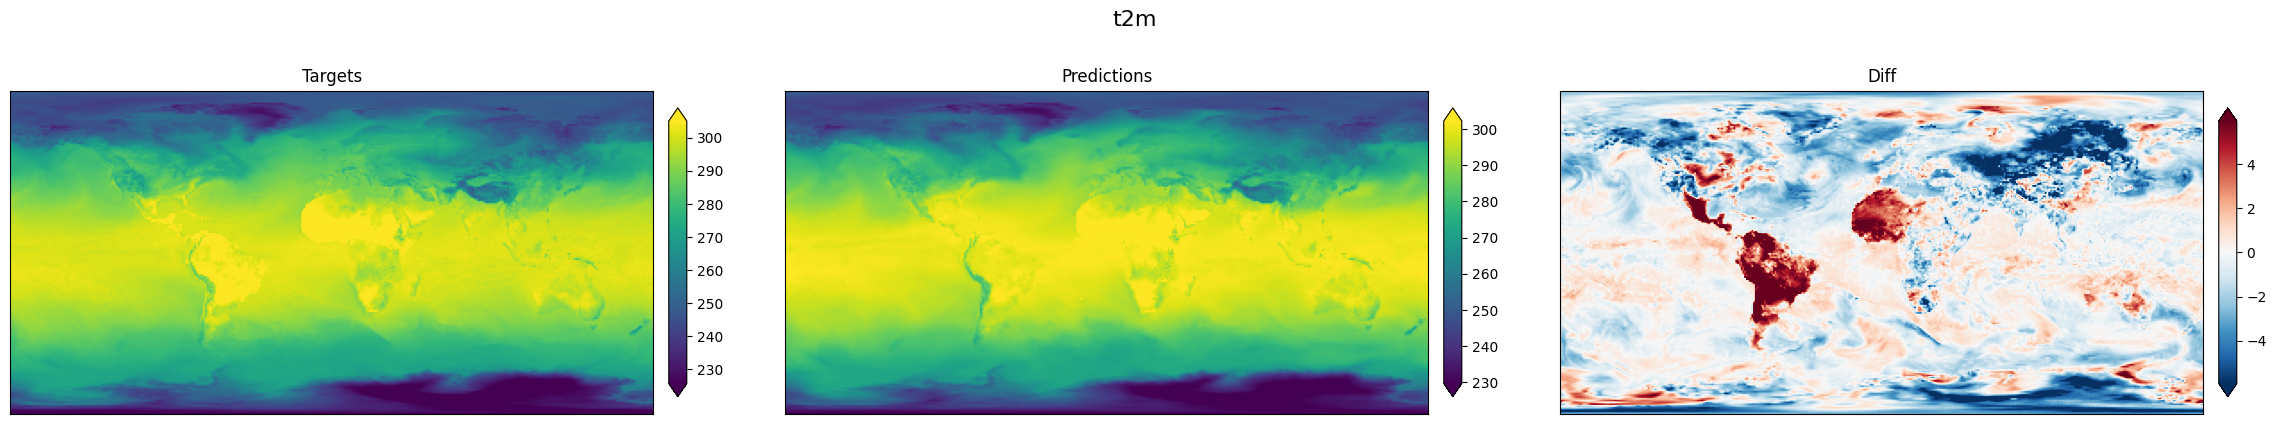

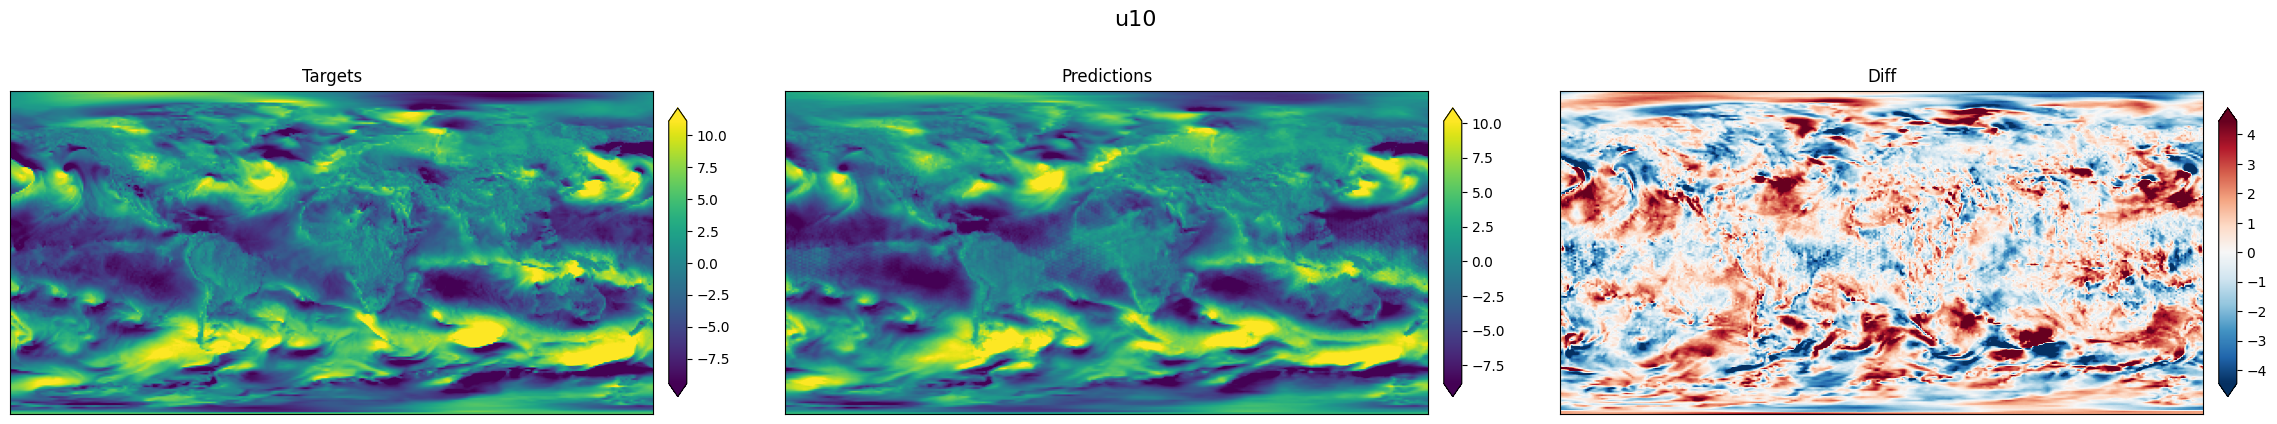

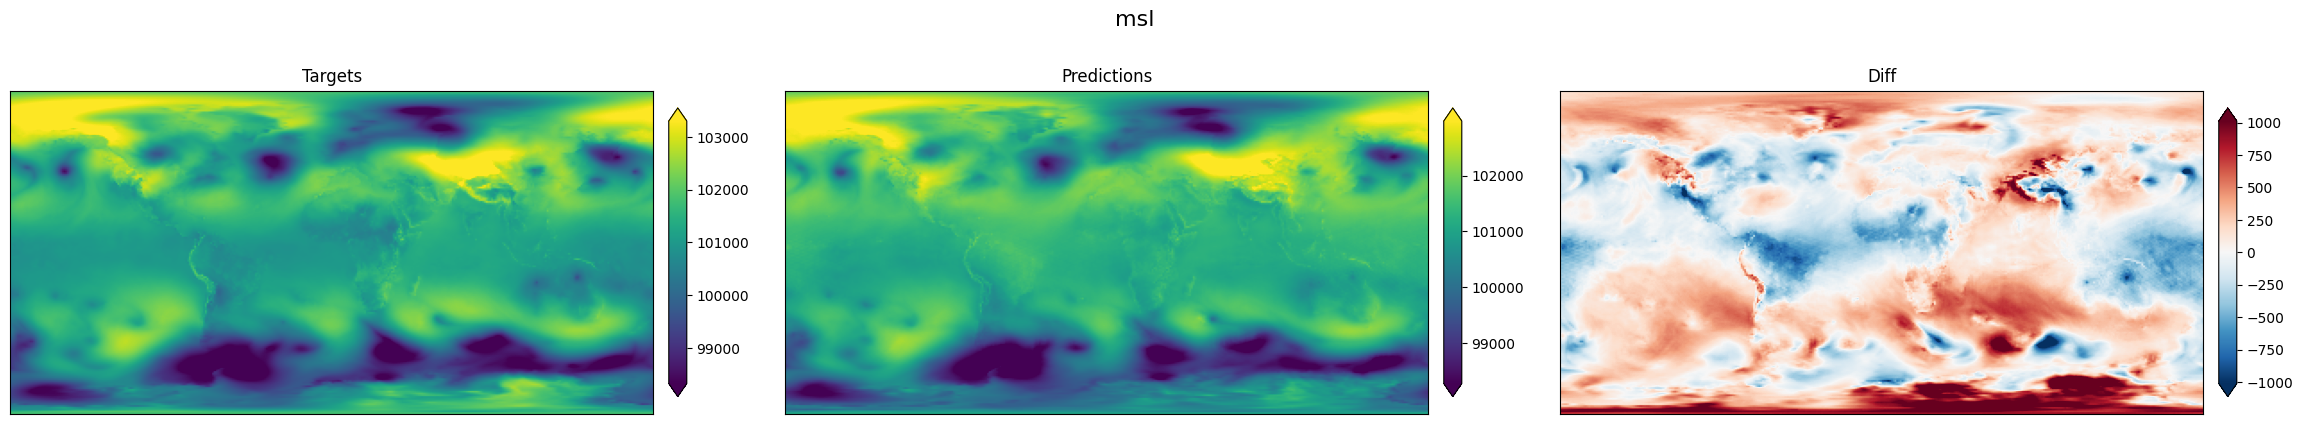

In [13]:
plot_size = 5

plot_pred_level = 50
plot_pred_robust = True
plot_max_steps = 1 # min(predictions.dims["time"], plot_pred_max_steps.value)


# eval_targets = example_batch

variables = ["t2m", "u10", "msl"]

for variable in variables:
  plot_pred_variable = variable

  data = {
      "Targets": scale(select(eval_targets, plot_pred_variable, plot_pred_level, plot_max_steps), robust=plot_pred_robust),
      "Predictions": scale(select(predictions, plot_pred_variable, plot_pred_level, plot_max_steps), robust=plot_pred_robust),
      "Diff": scale((select(eval_targets, plot_pred_variable, plot_pred_level, plot_max_steps) -
                          select(predictions, plot_pred_variable, plot_pred_level, plot_max_steps)),
                        robust=plot_pred_robust, center=0),
  }
  fig_title = plot_pred_variable
  if "level" in predictions[plot_pred_variable].coords:
    fig_title += f" at {plot_pred_level} hPa"

  plot_data(data, fig_title, plot_size, plot_pred_robust)